# Data Science Project Planning: Predicting Newsletter Subscription in Minecraft Players

## Introduction
This report explores a dataset from a UBC research group studying player behavior in a Minecraft server. The goal is to predict which types of players are most likely to subscribe to a game-related newsletter based on their characteristics and playing patterns.

In [2]:
library(tidyverse)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [8]:
players <- read_csv("INDIVIDUAL_STAGE_PROJECT/Data/players.csv")
sessions <- read_csv("INDIVIDUAL_STAGE_PROJECT/Data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 1. Data Description

### Datasets Overview
This project uses two datasets collected from a Minecraft research server operated by the PLAI group at UBC:

**Dataset 1: players.csv**
- Contains information about individual players who have joined the server
- Each row represents one unique player

**Dataset 2: sessions.csv**
- Contains information about individual play sessions
- Each row represents one gaming session by a player
- Players can have multiple sessions

In [15]:
players_vars <- tibble(
    `Variable Name` = c('experience', 'subscribe', 'hashedEmail', 'played_hours', 'name', 'gender', 'Age'),
    Type = c('Categorical', 'Boolean', 'Text', 'Numeric', 'Text', 'Categorical', 'Numeric'),
    Description = c(
        'Player gaming experience level (Beginner, Amateur, Regular, Veteran, Pro)',
        'Whether player subscribed to newsletter (TRUE/FALSE)',
        'Anonymized unique identifier for each player',
        'Total hours played on the server',
        'Player username',
        'Self-reported gender identity',
        'Player age in years'
    )
)

players_vars
sessions_vars <- tibble(
    `Variable Name` = c('hashedEmail', 'start_time', 'end_time', 'original_start_time', 'original_end_time'),
    Type = c('Text', 'DateTime', 'DateTime', 'Numeric', 'Numeric'),
    Description = c(
        'Anonymized player identifier (links to players.csv)',
        'Session start date and time (formatted)',
        'Session end date and time (formatted)',
        'Session start timestamp (Unix epoch)',
        'Session end timestamp (Unix epoch)'
    )
)

sessions_vars

Variable Name,Type,Description
<chr>,<chr>,<chr>
experience,Categorical,"Player gaming experience level (Beginner, Amateur, Regular, Veteran, Pro)"
subscribe,Boolean,Whether player subscribed to newsletter (TRUE/FALSE)
hashedEmail,Text,Anonymized unique identifier for each player
played_hours,Numeric,Total hours played on the server
name,Text,Player username
gender,Categorical,Self-reported gender identity
Age,Numeric,Player age in years


Variable Name,Type,Description
<chr>,<chr>,<chr>
hashedEmail,Text,Anonymized player identifier (links to players.csv)
start_time,DateTime,Session start date and time (formatted)
end_time,DateTime,Session end date and time (formatted)
original_start_time,Numeric,Session start timestamp (Unix epoch)
original_end_time,Numeric,Session end timestamp (Unix epoch)


In [17]:
players |>
    select(played_hours, Age) |>
    summary()
table(players$experience)
table(players$subscribe)
table(players$gender)

  played_hours          Age       
 Min.   :  0.000   Min.   : 9.00  
 1st Qu.:  0.000   1st Qu.:17.00  
 Median :  0.100   Median :19.00  
 Mean   :  5.846   Mean   :21.14  
 3rd Qu.:  0.600   3rd Qu.:22.75  
 Max.   :223.100   Max.   :58.00  
                   NA's   :2      


 Amateur Beginner      Pro  Regular  Veteran 
      63       35       14       36       48 


FALSE  TRUE 
   52   144 


          Agender            Female              Male        Non-binary 
                2                37               124                15 
            Other Prefer not to say      Two-Spirited 
                1                11                 6 

In [19]:
tibble(
    Variable = c('played_hours', 'Age'),
    Mean = c(
        round(mean(players$played_hours, na.rm = TRUE), 2),
        round(mean(players$Age, na.rm = TRUE), 2)
    )
)

Variable,Mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


### Data Quality Observations

**Issues Identified:**
- **Gender data inconsistency:** Some entries show mismatched gender and names (e.g., male names with female gender), suggesting potential data entry errors or non-traditional gender identities
- **Zero played hours:** Many players have 0 hours played but have subscribed, which seems unusual and may indicate players who signed up but haven't played yet
- **Session timestamps:** The original timestamp columns are in scientific notation which will need conversion for analysis
- **Missing data potential:** Need to check for any NULL or missing values in key variables

**Data Collection Method:**
Based on the documentation, this data was collected automatically from the Minecraft server as players registered and played. Player characteristics (age, gender, experience level) were likely self-reported during registration, while playing hours and session data were tracked programmatically.

## 2. Research Questions

### Broad Question
**Question 1:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Question
**Can player experience level, age, gender, and hours played predict whether a player will subscribe to the game newsletter?**

This question will help the research team understand which player demographics and behaviors correlate with newsletter engagement, allowing them to better target their recruitment and communication strategies.

### How the Data Addresses the Question
- **Response variable:** `subscribe` (binary: TRUE/FALSE)
- **Explanatory variables:** 
  - `experience` (categorical: Beginner, Amateur, Regular, Veteran, Pro)
  - `Age` (numeric: player age in years)
  - `gender` (categorical: Male, Female, Non-binary, etc.)
  - `played_hours` (numeric: total hours played)

The players.csv dataset contains all necessary variables to build a classification model that predicts subscription status based on player characteristics.

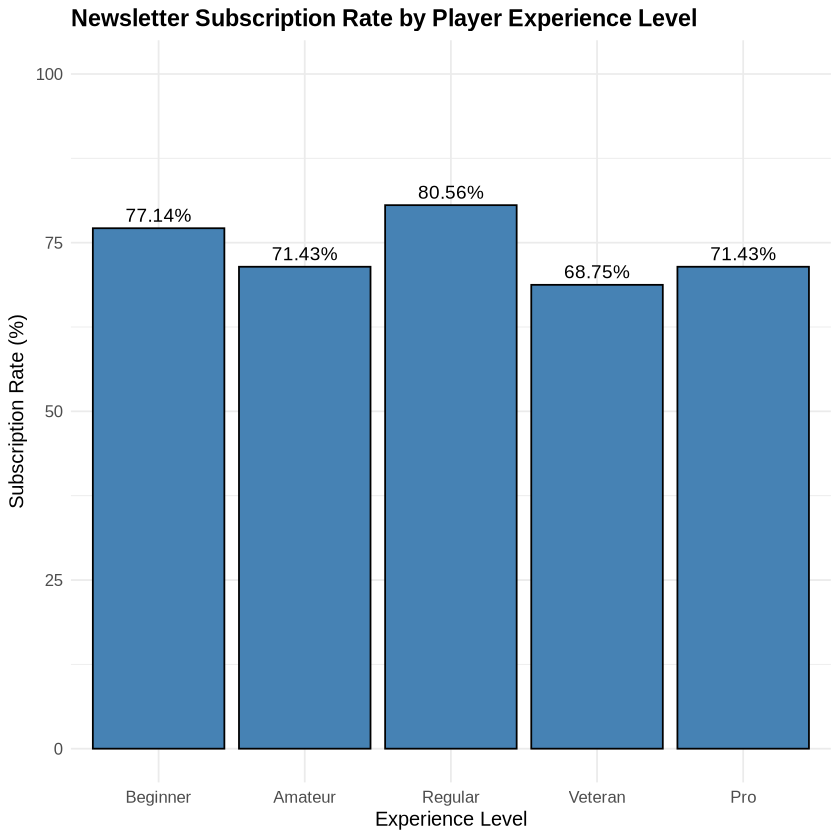

In [21]:
exp_subscribe <- players |>
    group_by(experience) |>
    summarise(subscription_rate = round(mean(subscribe) * 100, 2), .groups = 'drop') |>
    mutate(experience = factor(experience, 
                               levels = c('Beginner', 'Amateur', 'Regular', 'Veteran', 'Pro'))) |>
    arrange(experience)

ggplot(exp_subscribe, aes(x = experience, y = subscription_rate)) +
    geom_bar(stat = 'identity', fill = 'steelblue', color = 'black') +
    geom_text(aes(label = paste0(subscription_rate, '%')), vjust = -0.5, size = 4) +
    labs(
        title = 'Newsletter Subscription Rate by Player Experience Level',
        x = 'Experience Level',
        y = 'Subscription Rate (%)'
    ) +
    theme_minimal() +
    theme(
        plot.title = element_text(face = 'bold', size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10)
    ) +
    ylim(0, 100)

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


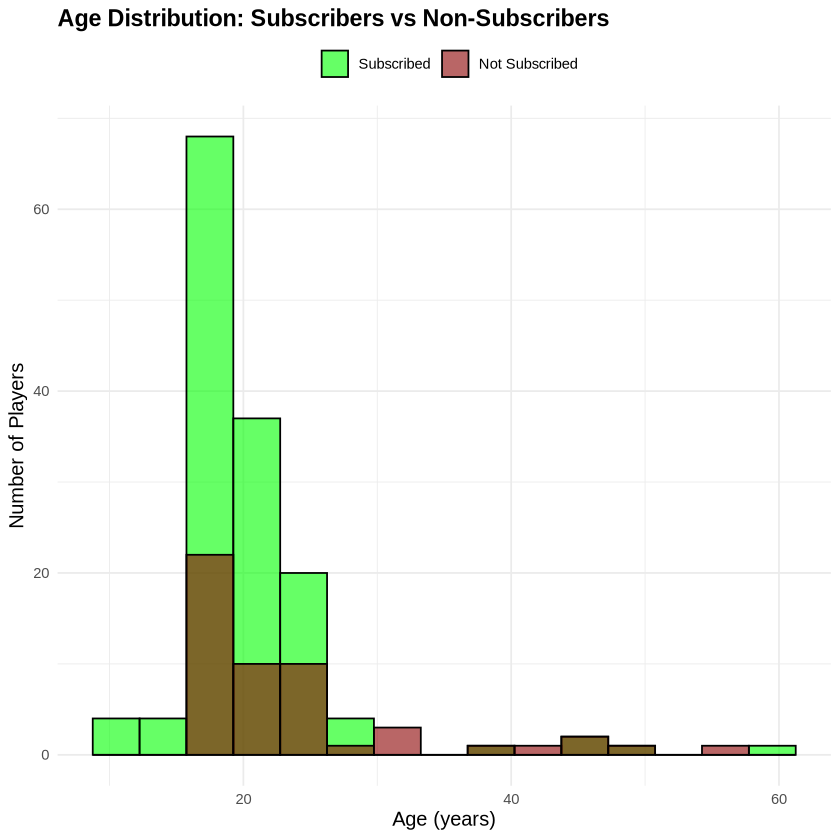

In [34]:
players_ordered <- players %>%
    mutate(subscribe = factor(subscribe, levels = c('TRUE', 'FALSE')))

ggplot(players_ordered, aes(x = Age, fill = subscribe)) +
    geom_histogram(bins = 15, alpha = 0.6, color = 'black', position = 'identity') +
    scale_fill_manual(values = c('TRUE' = 'green', 'FALSE' = 'darkred'),
                      labels = c('TRUE' = 'Subscribed', 'FALSE' = 'Not Subscribed'),
                      name = '') +
    labs(
        title = 'Age Distribution: Subscribers vs Non-Subscribers',
        x = 'Age (years)',
        y = 'Number of Players'
    ) +
    theme_minimal() +
    theme(
        plot.title = element_text(face = 'bold', size = 14),
        axis.title = element_text(size = 12),
        legend.position = 'top'
    )

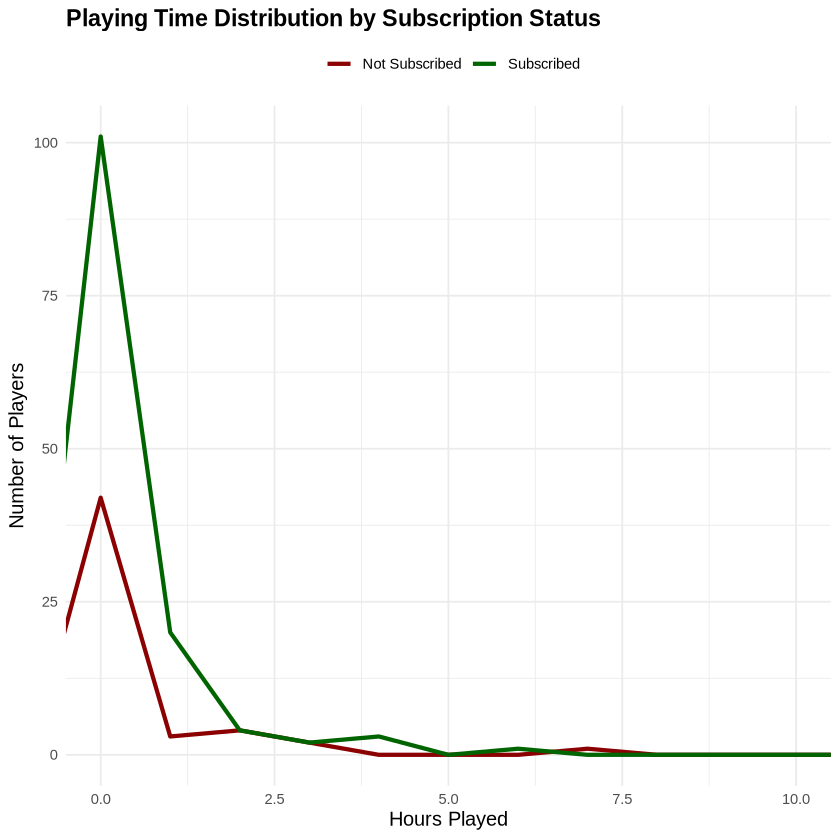

In [37]:
players_plot <- players |>
    mutate(subscribe_label = ifelse(subscribe, 'Subscribed', 'Not Subscribed'))

ggplot(players_plot, aes(x = played_hours, color = subscribe_label)) +
    geom_freqpoly(binwidth = 1, size = 1.2) +
    scale_color_manual(values = c('Subscribed' = 'darkgreen', 'Not Subscribed' = 'darkred')) +
    coord_cartesian(xlim = c(0, 10)) +
    labs(
        title = 'Playing Time Distribution by Subscription Status',
        x = 'Hours Played',
        y = 'Number of Players',
        color = ''
    ) +
    theme_minimal() +
    theme(
        plot.title = element_text(face = 'bold', size = 14),
        axis.title = element_text(size = 12),
        legend.position = 'top'
    )

In [41]:
cat("MISSING VALUES IN PLAYERS DATASET:\n")
players |>
    summarise(across(everything(), ~sum(is.na(.))))

cat("\nMISSING VALUES IN SESSIONS DATASET:\n")
sessions |>
    summarise(across(everything(), ~sum(is.na(.))))

cat("\nCORRELATION BETWEEN NUMERIC VARIABLES:\n")
players |>
    mutate(subscribe_numeric = as.numeric(subscribe)) |>
    select(played_hours, Age, subscribe_numeric) |>
    cor(use = "complete.obs") |>
    round(2)

MISSING VALUES IN PLAYERS DATASET:


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,2



MISSING VALUES IN SESSIONS DATASET:


hashedEmail,start_time,end_time,original_start_time,original_end_time
<int>,<int>,<int>,<int>,<int>
0,0,2,0,2



CORRELATION BETWEEN NUMERIC VARIABLES:


,played_hours,Age,subscribe_numeric
played_hours,1.00,-0.06,0.12
Age,-0.06,1.00,-0.21
subscribe_numeric,0.12,-0.21,1.00


## 3. Proposed Methods and Plan

### Selected Method: Logistic Regression

**Why this method is appropriate:**
- Logistic regression is ideal for binary classification problems (subscribe: YES/NO)
- It provides interpretable coefficients showing how each predictor influences subscription probability
- It handles both categorical and numeric predictors well
- It's computationally efficient and a standard baseline for classification tasks

**Required Assumptions:**
1. **Independence:** Each player's subscription decision is independent of others
2. **Linearity:** There is a linear relationship between predictor variables and the log-odds of subscription
3. **No multicollinearity:** Predictor variables should not be highly correlated with each other
4. **Large sample size:** We have 197 observations, which should be sufficient

**Potential Limitations:**
- Logistic regression assumes linear relationships in log-odds space, which may not capture complex non-linear patterns
- If important predictors are missing, the model's predictive power may be limited
- Class imbalance (if most players subscribe or don't subscribe) could affect model performance
- The model treats all misclassifications equally, which may not reflect real-world costs

### Model Comparison and Selection

**Comparison approach:**
- Compare logistic regression with at least one alternative method (e.g., decision tree classifier)
- Use cross-validation to assess generalization performance
- Evaluate models using multiple metrics:
  - **Accuracy:** Overall correct prediction rate
  - **Precision and Recall:** To understand false positives vs false negatives
  - **ROC-AUC score:** To assess model's ability to discriminate between classes
  - **F1-score:** Harmonic mean of precision and recall

**Model selection criteria:**
- Select the model with the best cross-validation performance
- Consider model interpretability for stakeholder communication
- Assess practical significance alongside statistical performance

### Data Processing Plan

**Data splitting strategy:**
1. **Initial split:** Divide data into 75% training and 25% test set
2. **Timing of split:** Split will occur after initial data cleaning but before feature engineering to prevent data leakage
3. **Stratification:** Use stratified sampling to ensure balanced representation of subscription classes in both sets
4. **Cross-validation:** Implement 5-fold cross-validation on the training set for hyperparameter tuning
5. **Validation set:** Use cross-validation within training data instead of a separate validation set to maximize training data utilization

**Pre-processing steps:**
1. Handle missing values (if any are found)
2. Encode categorical variables (`experience`, `gender`) using dummy/indicator variables
3. Standardize numeric variables (`Age`, `played_hours`) to have mean=0 and std=1
4. Check for and address class imbalance if present
5. Feature engineering: may create interaction terms or polynomial features if initial model performance is poor

**Workflow:**
```
Raw Data → Clean & Explore → Split (75/25) → Preprocess → Train Models → Cross-Validate → Select Best → Evaluate on Test Set → Report Results
```